# CSLVAE demo

This notebook briefly illustrates some of CSLVAE's capabilities. Using a trained `CSLVAE` module and a `CSLDataset` dataset, we construct a `CSLVAEDB` module that essentially serves as a surrogate for the dataset, permitting a fast retrieval strategy via autoencoding. Importantly, `CSLVAEDB` possesses an `encode` and `decode` method. The `encode` method takes a list of SMILES strings as input and produces as output queries (a `(batch_size, query_dim)` tensor), while the `decode` method takes queries as input and returns as output products from the `CSLDataset`.

The notebook proceeds as follows:
- Load a combinatorial synthesis library as a `CSLDataset`.
- Load the trained `CSLVAE` module.
- Fit a `CSLVAEDB` instance from the trained `CSLVAE` module and the `CSLDataset`, which registers parameters for synthon, R-group, and reaction keys/embeddings, in addition to the relevant indexes used in decoding the reaction and R-group assignments.
- Run through the qualitative exercises from the paper:
  - Autoencoding for analogue retrieval.
  - Library-constrained interpolation.
  - Visualizing a 2D cross-section in the CSLVAE latent space.

In [1]:
import numpy as np
import os
import torch
import yaml
from itertools import groupby 
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw

from cslvae.dataset import CSLDataset
from cslvae.nn import CSLVAE, CSLVAEDB


# Local path to CSLVAE install
cslvae_path = "..."


In [2]:
# Load the CSL
reaction_smarts_path = "..."
synthon_smiles_path = "..."
dataset = CSLDataset(reaction_smarts_path, synthon_smiles_path)

print(f"Number of reactions: {dataset.num_reactions:,}.")
print(f"Number of synthons: {dataset.num_synthons:,}.")
print(f"Number of products: {len(dataset):,}.")


Number of reactions: 4.
Number of synthons: 6,080.
Number of products: 115,822,580.


In [3]:
# Load config of the model architecture
config_path = os.path.join(cslvae_path, "configs/train_cslvae_config.yaml")
with open(config_path) as f:
    config = yaml.safe_load(f)

# Load the trained CSLVAE model
cslvae = CSLVAE(**config["model"])
model_path = os.path.join(cslvae_path, "models/cslvae.pt")
model_state_dict = torch.load(model_path, map_location="cpu")
cslvae.load_state_dict(model_state_dict["model_state_dict"])


<All keys matched successfully>

In [4]:
# The CSLVAEDB combines the trained CSLVAE model with a CSLDataset. CSLVAEDB instances have a decode method
# which retrieves from the CSLDataset directly, guaranteeing that all compounds generated by the decoder are
# contained in the CSLDataset
cslvaedb = CSLVAEDB(cslvae, dataset)
cslvaedb.fit({"batch_size": 256})


Encoding 6,080 synthons.
Synthon encoding complete after 56.46 seconds.
Library encoding complete.


In [5]:
# Function to calculate ECFP simarility between a query molecule and a list of molecules
def calculate_pairwise_tanimoto(query_mol, key_mols, radius=2, nBits=1024):
    fp_query = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius, nBits=nBits)
    fp_keys = [AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nBits) for m in key_mols]
    return [DataStructs.TanimotoSimilarity(fp_query, fp) for fp in fp_keys]


# Autoencoding for analogue retrieval

Index: 54561531
SMILES: CCN(CCNC(=O)c1cc(Cl)cc2ccncc12)C(=O)CCCc1ccc(C)cc1
Number of unique retrievals: 24/24


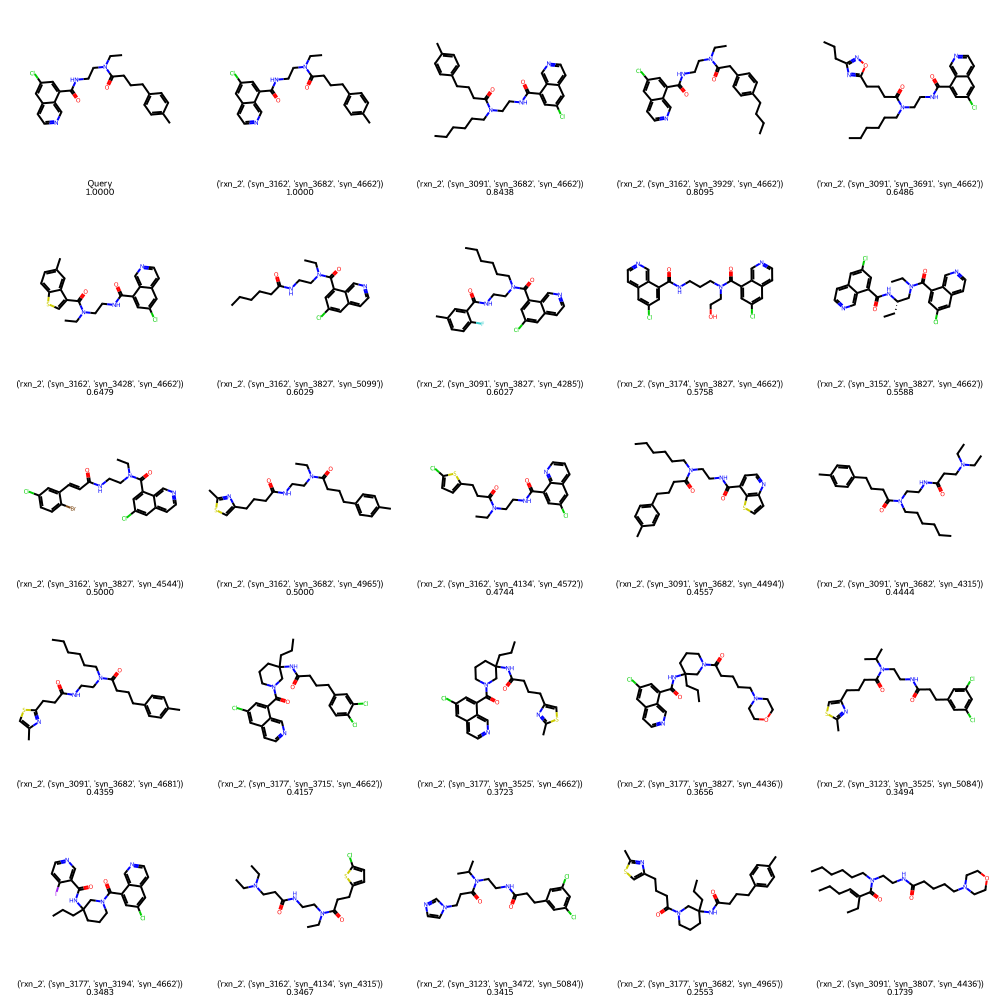

In [6]:
# Sample a random product from the CSLDataset
i = np.random.randint(0, len(dataset))
item = dataset[i]
query_product = item["product"]
smi = Chem.MolToSmiles(query_product.mol)

# Encode the product and decode the resulting query multiple times to stochastically retrieve from the library
n_queries = 24
query = cslvaedb.encode([smi])
responses = cslvaedb.decode(
    queries=query.repeat(n_queries, 1),
    reaction_temperature=1.0,
    synthon_temperature=10.0,
)
smiles = [s for s, _ in responses]
keys = [str(k) for _, k in responses]

# Remove duplicates
smiles, idx = np.unique(smiles, return_index=True)
smiles = smiles.tolist()
keys = np.array(keys)[idx].tolist()

# Calculate Tanimoto similarity of each sampled retrieval with the query molecule
mols = [Chem.MolFromSmiles(s) for s in smiles]
sims = calculate_pairwise_tanimoto(query_product.mol, mols)

# Sort by Tanimoto similarity and label each molecule with its product (reaction, R-group assignment) and
# Tanimoto similarity to query
idx = np.argsort(sims)[::-1]
mols = [query_product.mol] + np.array(mols)[idx].tolist()
keys = ["Query"] + np.array(keys)[idx].tolist()
sims = [1.0] + np.array(sims)[idx].tolist()
legends = [i + "\n" + f"{j:.4f}" for i, j in zip(keys, sims)]

print(f"Index: {i}")
print(f"SMILES: {smi}")
print(f"Number of unique retrievals: {len(smiles)}/{n_queries}")

# Visualize
Draw.MolsToGridImage(mols, molsPerRow=5, maxMols=len(mols), legends=legends, useSVG=True)


# Generating in-library interpolations (hybrids) between two queries

Intermediates generated: 5


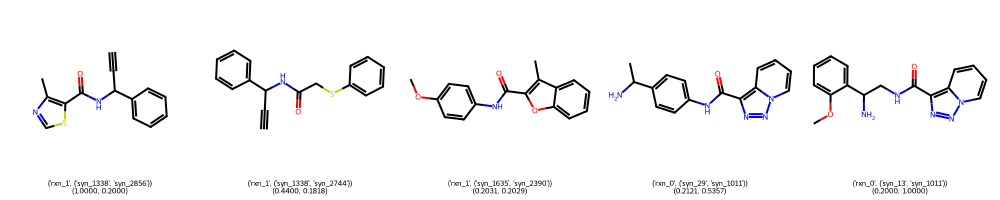

In [7]:
# Sample two random queries and form sequence of linear interpolatations between them
n_steps = 25
w0 = torch.linspace(0, 1, n_steps).view(-1, 1)
w1 = 1 - w0
q0, q1 = torch.randn(2, 1, cslvae.query_dim)
queries = w0 * q0 + w1 * q1

# Decode deterministically (i.e., zero temperature) and remove consecutive duplicates
responses = cslvaedb.decode(queries, reaction_temperature=0.0, synthon_temperature=0.0)
smiles = [s for s, _ in responses]
keys = [str(k) for _, k in responses]
smiles = [i[0] for i in groupby(smiles)]
keys = [i[0] for i in groupby(keys)]

print(f"Intermediates generated: {len(smiles)}")

# For each molecule, get Tanimoto similarity with starting and ending molecule in the sequence for the plot legend
mols = [Chem.MolFromSmiles(s) for s in smiles]
sim_start = calculate_pairwise_tanimoto(mols[0], mols)
sim_end = calculate_pairwise_tanimoto(mols[-1], mols)
sims = [f"({x:.4f}, {y:.4f})" for x, y in zip(sim_start, sim_end)]
legends = [i + "\n" + j for i, j in zip(keys, sims)]

# Visualize
Draw.MolsToGridImage(mols, molsPerRow=len(mols), legends=legends, useSVG=True)


# Visualizing a 2D cross-section in the CSLVAE latent space

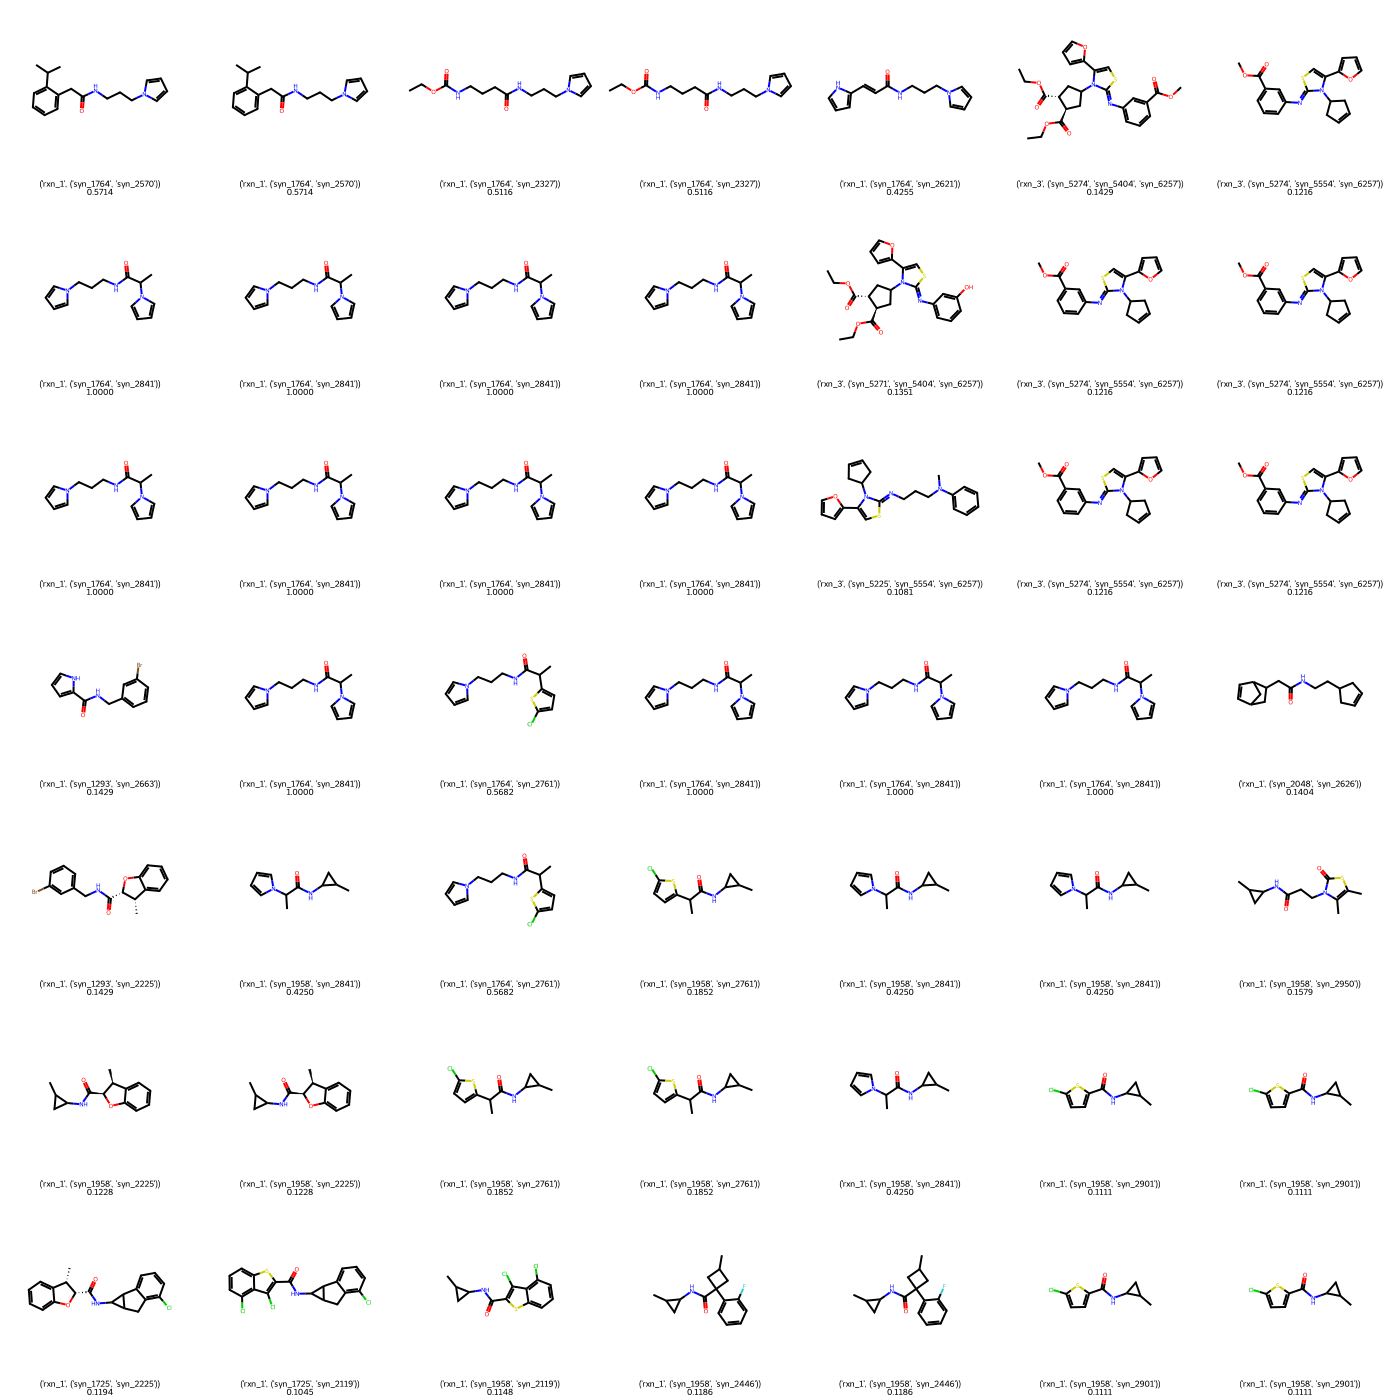

In [8]:
# The local neighborhood will be visualized as a (2k + 1) x (2k + 1) grid centered on a randomly
# sampled product from the CSLDataset
k = 3

# Sample a random query and two random directions in latent space
i = np.random.randint(len(dataset))
query = torch.randn(1, cslvae.query_dim)
e0 = torch.randn_like(query)
e1 = torch.randn_like(query)

# Generate points along 2D plane embedded in the latent space
sigma = 2.0
q1 = torch.stack([torch.lerp(query - sigma * e0, query + sigma * e0, i) for i in torch.linspace(0, 1, 2 * k + 1)])
q2 = torch.stack([torch.lerp(query - sigma * e1, query + sigma * e1, i) for i in torch.linspace(0, 1, 2 * k + 1)])
queries = ((q1[None, :, :] + q2[:, None, :]) / 2).view(-1, cslvae.query_dim)
queries = torch.cat([query.view(1, -1), queries], 0)

# Decode deterministically (i.e., zero temperature) and calculate Tanimoto similarity to center molecule in 2D grid 
responses = cslvaedb.decode(queries, reaction_temperature=0.0, synthon_temperature=0.0)
mols = [Chem.MolFromSmiles(s) for s, _ in responses]
keys = [str(k) for _, k in responses]
sims = calculate_pairwise_tanimoto(mols[0], mols[1:])
legends = [i + "\n" + f"{j:.4f}" for i, j in zip(keys[1:], sims)]

# Visualize
Draw.MolsToGridImage(mols[1:], molsPerRow=2 * k + 1, maxMols=(2 * k + 1) ** 2, legends=legends, useSVG=True)
